In [2]:
#@@@@@@@@@@@@@@@@@@@@@@@
#import useful libraries
#@@@@@@@@@@@@@@@@@@@@@@@
import pandas as pd
import numpy as np
import copy
from scipy import interpolate
from scipy.stats import truncnorm
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from pydantic import BaseModel
import csv
import os
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List, Dict
import time

from game import TheGang
from models import HandFeatures

In [3]:
import torch

# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU


In [4]:
#@@@@@@@@@@@@@@@@@@@@@
#Simple profiler class
#@@@@@@@@@@@@@@@@@@@@@
class Profiler:
    def __init__(self):
        self.checkpoint_times: Dict[str, List[float]] = {}
        self.checkpoint_start_times: Dict[str, float] = {}

    def reset(self):
        self.checkpoint_times: Dict[str, List[float]] = {}
        self.checkpoint_start_times: Dict[str, float] = {}

    def start(self, checkpoint: str):
        start_time = time.time()
        self.checkpoint_start_times[checkpoint] = start_time

    def stop(self, checkpoint: str):
        stop_time = time.time()
        start_time = self.checkpoint_start_times.get(checkpoint, 0)
        if start_time == 0:
            raise Exception("No start time for the current checkpoint")
        duration = stop_time - start_time
        existing_checkpoint = self.checkpoint_times.get(checkpoint, None)
        if existing_checkpoint:
            existing_checkpoint.append(duration)
        else:
            self.checkpoint_times[checkpoint] = [duration]

    def report(self):
        for checkpoint, values in self.checkpoint_times.items():
            iters = len(values)
            max_time = max(values)
            min_time = min(values)
            average_time = np.mean(values)
            range = max(max_time - average_time, average_time - min_time)
            print("%-20s | %.4f s ± %.4f s per iteration | n_iters = %d" % (checkpoint[:20], average_time, range, iters))

In [5]:
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_layer_size, hidden_layer_count = 1):
        super(PolicyNetwork, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(input_size, hidden_layer_size))
        nn.init.normal_(self.hidden_layers[0].weight, mean = 0, std = 0.01)
        nn.init.normal_(self.hidden_layers[0].bias, mean = 0, std = 0.01)
        for _ in range(hidden_layer_count-1):
            layer = nn.Linear(hidden_layer_size, hidden_layer_size)
            self.hidden_layers.append(layer)
            nn.init.normal_(layer.weight, mean = 0, std = 0.01)
            nn.init.normal_(layer.bias, mean = 0, std = 0.01)
        self.output_layer = nn.Linear(hidden_layer_size, 4)    #the output layer with probabiliy for each action
        self.output_layer.bias = nn.Parameter(torch.tensor([0.0, 0.0, 0.0, 0.0])) 

    def forward(self, s: torch.Tensor) -> torch.Tensor:
        '''A function to do the forward pass
            Takes:
                s -- the state representation
            Returns:
                a tensor of probabilities
        '''         
        s = s.to(next(self.parameters()).device)
        for layer in self.hidden_layers:
             s = torch.relu(layer(s))    #pass through the hidden layers
        s = self.output_layer(s)
        action_probs = torch.softmax(s, dim=1)    #use softmax to get action probabilities
        return action_probs.to('cpu')


In [6]:
class AgentConfig(BaseModel):
    hidden_layer_size: int = 32
    hidden_layer_count: int = 8
    learning_rate: float = 0.0005

class Agent():
    def __init__(self, config: AgentConfig):
        self.config = config
        self.pi = PolicyNetwork(17, config.hidden_layer_size, config.hidden_layer_count).to(device)
        self.optimizer = optim.Adam(self.pi.parameters(), lr=self.config.learning_rate)

    def generate_actions(self, state_array: List[List[int]]):
        action_probs = self.pi(torch.tensor(state_array, dtype=torch.float32)) # Create tensor and feed state through model
        sampled_actions = torch.multinomial(action_probs, 1).squeeze(dim=1)
        action_space = torch.tensor([1, 2, 3, 4])
        final_actions = action_space[sampled_actions]
        return final_actions

    def generate_action_probs(self, a: List[int], state_array: List[List[int]]):
        all_action_probs = self.pi(torch.tensor(state_array, dtype=torch.float32)) # Create tensor and feed state through model
        a_tensor = torch.tensor(a, dtype=torch.long)
        a_tensor = a_tensor - 1
        performed_action_probs = all_action_probs.gather(1, a_tensor.unsqueeze(1)).squeeze(1)
        log_probs = torch.log(performed_action_probs)
        return log_probs

    def checkpoint(self, model_name, epoch_count: int):
        directory = f'checkpoints/{model_name}'
        os.makedirs(directory, exist_ok=True)
        torch.save(self.pi.state_dict(), f'{directory}/epi_{epoch_count}.pth')
        
    def load_checkpoint(self, model_name: str, epoch_count: int):
        self.pi.load_state_dict(torch.load(f'checkpoints/{model_name}/epi_{epoch_count}.pth'))


In [7]:
class TrainingConfig(BaseModel):
    discount_factor: float = 0.5
    batch_size: int = 100
    checkpoint_freq: int = 2000

In [8]:
def train_agent(
    agent: Agent,
    env: TheGang,
    training_config: TrainingConfig,
    num_epochs: int,
    starting_epoch: int,
    model_name: str,
    profiler: Profiler = None
):
    average_epoch_rewards = []
    for epoch in tqdm(range(num_epochs)):
        if profiler:
            profiler.start("epoch")

        epoch_batch_rewards = []
        batch = []
        # Repead episodes until epoch batch size is reached
        for epi in range(training_config.batch_size):
            if profiler:
                profiler.start("episode")
    
            env.reset()

            episode_rewards = []
            episode_states = []
            episode_actions = []
            state = {'state':env.generate_state_array([0,0,0,0]),'reward':[0,0,0,0],'done':False}

            # Loop turns in episode
            while not state['done']:
                episode_states.append(state['state'])
                
                if profiler:
                    profiler.start("action generation")
                
                a = agent.generate_actions(state['state']).tolist()
                
                if profiler:
                    profiler.stop("action generation")
                    profiler.start("environment step")
                
                episode_actions.append(a)
                state = env.step(a)
                episode_rewards.append(state['reward'])
                
                if profiler:
                    profiler.stop("environment step")

            # Track fire rate and terminal rewards for non-fired episodes
            epoch_batch_rewards.extend(episode_rewards)

            if profiler:
                profiler.start("calculate causal returns")

            # Calcualte causal reward
            causal_returns = []
            rolling_causal_return = np.zeros(len(episode_rewards[0]))
            # Calculate causal returns in reverse order
            for rewards in episode_rewards[::-1]:
                causal_return = rewards + training_config.discount_factor * rolling_causal_return
                rolling_causal_return = causal_return
                causal_returns.append(causal_return)
            # Reverse the causal returns to get the correct order
            causal_returns = causal_returns[::-1]
            
            if profiler:
                profiler.stop("calculate causal returns")
                profiler.stop("episode")

            for state, action, reward, causal_return in zip(episode_states, episode_actions, episode_rewards, causal_returns):
                batch.append({'s_t': state, 'a_t': action, 'r_t': reward, 'cr_t': causal_return})

        # Calculate epoch performance
        average_epoch_rewards.append(np.mean(epoch_batch_rewards))
        
        # Checkpoint if applicable
        if epoch % training_config.checkpoint_freq == 0:
            agent.checkpoint(model_name, starting_epoch + epoch)
            with open(f'checkpoints/{model_name}/epoch_rewards.csv', 'w', newline="") as f:
                writer = csv.writer(f)
                writer.writerow(average_epoch_rewards)

        log_probs = []
        batch_causal_returns = []
        for step in batch:    # Loop over batch
            states = step['s_t']
            actions = step['a_t']
            if profiler:
                profiler.start("action prob generation")
            action_probs = agent.generate_action_probs(actions, states)    # Compute action probability from policy
            if profiler:
                profiler.stop("action prob generation")
            log_probs.append(action_probs.squeeze())    # Record the log probability of the chosen action
            batch_causal_returns.append(step['cr_t'])

        if profiler:
            profiler.start("update gradient")

        # Perform baselining
        baseline = np.mean(batch_causal_returns)
        baselined_causal_returns = batch_causal_returns - baseline

        baselined_causal_returns = torch.tensor(baselined_causal_returns)
        log_probs = torch.stack(log_probs)    #reshape to compute gradient over the whole episode #Shape: (batch_size, 4)

        objective = -torch.sum(log_probs * baselined_causal_returns)/len(batch) # Batch, and do "-" to convert "loss" to "gain"

        agent.optimizer.zero_grad()    #zero gradients from the previous step
        objective.backward()    #compute gradients
        agent.optimizer.step()
        
        if profiler:
            profiler.stop("update gradient")
            profiler.stop("epoch")

    agent.checkpoint(model_name, starting_epoch + num_epochs)
    with open(f'checkpoints/{model_name}/epoch_rewards.csv', 'w', newline="") as f:
        writer = csv.writer(f)
        writer.writerow(average_epoch_rewards)

    return average_epoch_rewards



In [9]:
agent_config = AgentConfig()
training_config = TrainingConfig()
agent = Agent(agent_config)
env = TheGang()
profiler = Profiler()
epoch_rewards = train_agent(agent, env, training_config, 10, 0, 'Profiling', profiler=profiler)

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


In [11]:
np.mean(epoch_rewards)

24.449375000000003

In [60]:
profiler.report()

action generation    | 0.0005 s ± 0.0011 s per iteration | n_iters = 4000
environment step     | 0.0004 s ± 0.0011 s per iteration | n_iters = 4000
calculate causal ret | 0.0000 s ± 0.0000 s per iteration | n_iters = 1000
episode              | 0.0040 s ± 0.0065 s per iteration | n_iters = 1000
action prob generati | 0.0004 s ± 0.0734 s per iteration | n_iters = 4000
update gradient      | 0.2393 s ± 0.0219 s per iteration | n_iters = 10
epoch                | 0.8035 s ± 0.0725 s per iteration | n_iters = 10


In [ ]:
agent_config = AgentConfig()
training_config = TrainingConfig()
agent = Agent(agent_config)
env = TheGang()
epoch_rewards = train_agent(agent, env, training_config, 40000, 0, 'Baseline_2')

  1%|          | 249/40000 [03:25<9:05:31,  1.21it/s]

In [75]:
np.mean(epoch_rewards)

34.15625

In [3]:
def read_average_rewards(model_name: str):
    with open(f"checkpoints/{model_name}/epoch_rewards.csv", "r") as f:
        reader = csv.reader(f)
        average_terminal_rewards = [float(value) for value in next(reader)]
    return average_terminal_rewards

In [6]:
epoch_rewards = read_average_rewards('Baseline_2')

In [11]:
def plot_rolling_mean(data, window: int, data_name: str):
    rolling_mean = pd.Series(data).rolling(window=window, min_periods=1).mean()

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=np.arange(len(rolling_mean)), y=rolling_mean, label="Fire Rate")


    # Add labels and title
    plt.title(f"{window}-Point Rolling Mean", fontsize=14)
    plt.xlabel("Training Duration (Epochs)", fontsize=12)
    plt.ylabel("Average Action Reward", fontsize=12)
    plt.grid()
    plt.savefig(data_name + "_" + str(window) + ".svg", format="svg")

    plt.show()

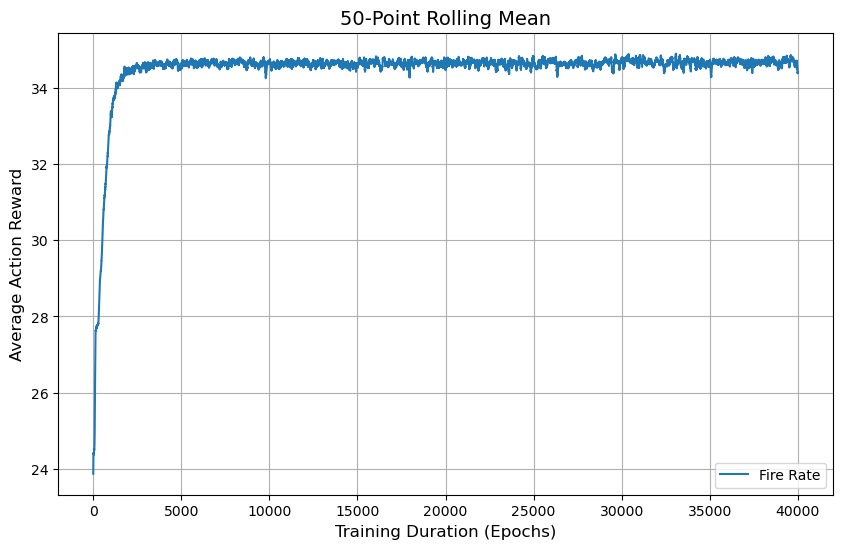

In [10]:
plot_rolling_mean(epoch_rewards, 50, "Baseline")

In [ ]:
agent_config = AgentConfig(
    hidden_layer_count=32
)
training_config = TrainingConfig(
    checkpoint_freq=1000
)
agent = Agent(agent_config)
env = TheGang()
epoch_rewards = train_agent(agent, env, training_config, 10000, 0, 'Baseline_Deep')

  0%|          | 35/10000 [01:21<6:00:48,  2.17s/it]

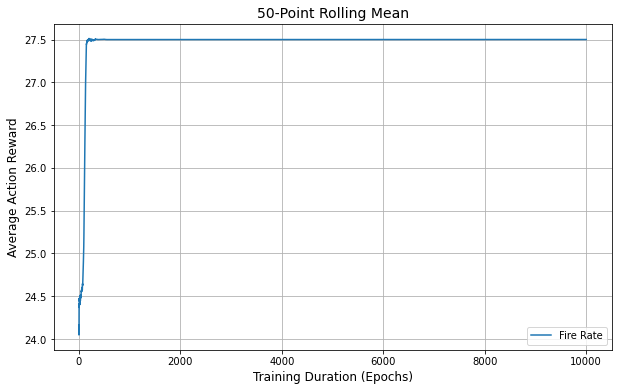

In [13]:
plot_rolling_mean(epoch_rewards, 50, "Deeper_Network")